# Homework 4
Christopher Beam

800927393

## General Setup

In [1]:
# Setup
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_breast_cancer
from collections import Counter
import seaborn as sns

In [2]:
data = load_breast_cancer()
X = data.data
Y = data.target
Y[Y==0] = -1

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
tempOnes_train = np.ones((len(Y_train), 1))
tempOnes_test = np.ones((len(Y_test),1))
iterations = 100

In [4]:
# Scale the input
X_scaler = StandardScaler()
X_scaler.fit(X_train)
X_train_std = X_scaler.transform(X_train)
X_test_std = X_scaler.transform(X_test)

In [5]:
# Kernel Functions

def linear(x, z):
    return x @ z.T

def polynomial(x, z, d):
    return np.power(x @ z.T, d)

def polynomial2(x, z, d):
    return np.power((x @ z.T) + 1, d)

def gaussian(x, z, sigma):
    return np.exp(-np.linalg.norm(x-z,axis=1)/(2*sigma**2))

def gaussian2(x, z, sigma):
    return np.exp(-np.linalg.norm(x-z)/(2*sigma**2))

def sigmoid_kernel(x, z, alpha, c):
    return np.tanh(alpha * (x @ z.T) + c)

polyD = 2
gaussianSigma = np.mean(X_scaler.var_)
sigAlpha = 1
sigC = 0

kernelFunc = [linear, lambda x,z: polynomial(x,z,polyD), lambda x,z: polynomial2(x,z,polyD), lambda x, z: gaussian(x, z, gaussianSigma), lambda x, z: sigmoid_kernel(x, z, sigAlpha, sigC)]
kernelNames = ["linear", 'polynomial', 'polynomial2', 'gaussian', 'sigmoid']
kernelFunc2 = [linear, lambda x,z: polynomial(x,z,polyD), lambda x,z: polynomial2(x,z,polyD), lambda x, z: gaussian(x, z, gaussianSigma)]
kernelNames2 = ["linear", 'polynomial', 'polynomial2', 'gaussian']

In [6]:
test1 = np.array([[1,2,3,9],[4,5,6,9],[7,8,9,9]])
test2 = np.array([[11,12,13],[14,15,16],[17,18,19]])
test3 = np.array([1,1,1,1])
for kernel in kernelFunc:
    kernelOut = kernel(test1,test3)
    print(kernelOut)
    #print(kernelOut.shape)
    #print(np.hstack((test1, kernelOut.reshape(kernelOut.shape[0],1))))

testZeros = np.zeros(test1.shape)
print(testZeros.shape)

[15 24 33]
[ 225  576 1089]
[ 256  625 1156]
[0.99999998 0.99999997 0.99999996]
[1. 1. 1.]
(3, 4)


In [7]:
def get_stats(input, targets):
    count = Counter(targets)
    keys = count.keys()

    means = []
    for k in keys:
        means.append(np.mean(input[targets==k], axis=0))
    means = np.array(means)

    variances = []
    for k in keys:
        variances.append(np.var(input[targets==k], axis=0, ddof=1))
    variances = np.array(variances)

    count = np.array(list(count.values()))
    prob = count/sum(count)
    return means, variances, prob

def pca(X, n):
    N = np.min(np.array([n, X.shape[1]]))
    covar_mat = np.cov(X.T)
    eigen_val, eigen_vec = np.linalg.eigh(covar_mat)

    sort_idx = np.argsort(eigen_val)[::-1]
    sorted_vec = eigen_vec[:,sort_idx]

    eigen_vec_subset = sorted_vec[:,0:N]
    return eigen_vec_subset.T.dot(X.T).T

def svm(x, y, kernel):
    out_x = np.zeros(x.shape)
    theta = np.zeros(x.shape[0])
    for xIdx in range(x.shape[0]):
        sample = x[xIdx,:]
        kernelOut = kernel(x,sample)
        output = kernelOut.dot(theta)
        if y[xIdx] == 1 and output < 0:
            theta[xIdx] = 1
            out_x[xIdx, :] = sample
        
        if y[xIdx] == -1 and output >= 0:
            theta[xIdx] = -1
            out_x[xIdx, :] = sample
    return out_x, theta

## Problem 1

In [8]:
kern_acc = []
kern_prec0 = []
kern_recall0 = []
kern_prec1 = []
kern_recall1 = []

for kernel in kernelFunc:
    acc_list = []
    prec0_list = []
    recall0_list = []
    prec1_list = []
    recall1_list = []
    for k in range(1,31):
        X_train_std_new = pca(X_train_std, k)
        X_test_std_new = pca(X_test_std, k)
        
        out_matrix, theta_x1 = svm(X_train_std_new, Y_train, kernel)

        pred_matrix = np.zeros(X_test_std_new.shape[0])
        for xIdx in range(X_test_std_new.shape[0]):
            sample = X_test_std_new[xIdx,:]
            kernelOut = kernel(out_matrix,sample)
            output = kernelOut.dot(theta_x1)
            pred_matrix[xIdx] = output

        pred_matrix[pred_matrix >= 0] = 1
        pred_matrix[pred_matrix < 0] = -1
        cnf_mat = confusion_matrix(Y_test, pred_matrix)


        acc_list.append((cnf_mat[0,0] + cnf_mat[1,1]) / np.sum(cnf_mat))
        prec0_list.append(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[1,1]))
        recall0_list.append(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[0,1]))
        prec1_list.append(cnf_mat[1,1]/(cnf_mat[0,0] + cnf_mat[1,1]))
        recall1_list.append(cnf_mat[1,1]/(cnf_mat[1,0] + cnf_mat[1,1]))

    kern_acc.append(acc_list)
    kern_prec0.append(prec0_list)
    kern_recall0.append(recall0_list)
    kern_prec1.append(prec1_list)
    kern_recall1.append(recall1_list)

linear: K with maximum accuracy = 3
linear: K with maximum precision for 0 = 5
linear: K with maximum recall for 0 = 3
linear: K with maximum precision for 1 = 2
linear: K with maximum recall for 1 = 2
polynomial: K with maximum accuracy = 10
polynomial: K with maximum precision for 0 = 1
polynomial: K with maximum recall for 0 = 1
polynomial: K with maximum precision for 1 = 8
polynomial: K with maximum recall for 1 = 8
polynomial2: K with maximum accuracy = 5
polynomial2: K with maximum precision for 0 = 14
polynomial2: K with maximum recall for 0 = 5
polynomial2: K with maximum precision for 1 = 4
polynomial2: K with maximum recall for 1 = 2
gaussian: K with maximum accuracy = 4
gaussian: K with maximum precision for 0 = 5
gaussian: K with maximum recall for 0 = 5
gaussian: K with maximum precision for 1 = 3
gaussian: K with maximum recall for 1 = 2
sigmoid: K with maximum accuracy = 4
sigmoid: K with maximum precision for 0 = 5
sigmoid: K with maximum recall for 0 = 5
sigmoid: K wi

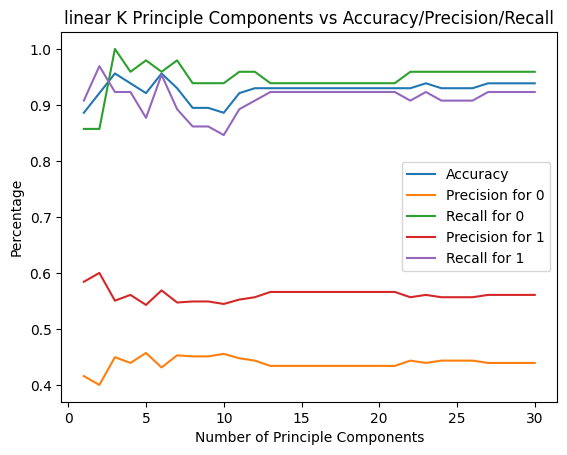

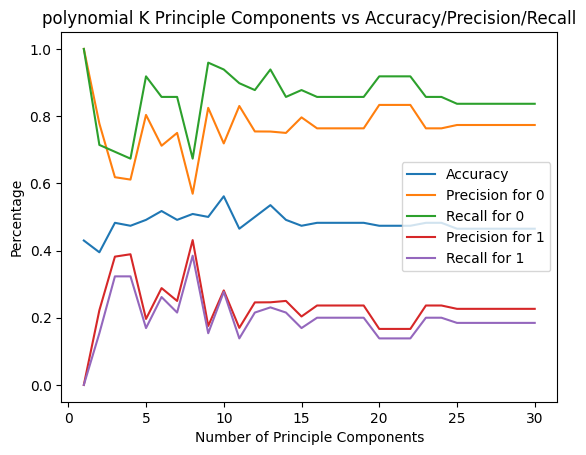

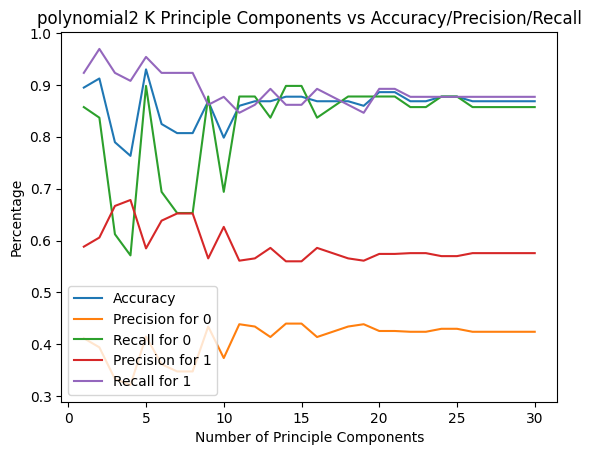

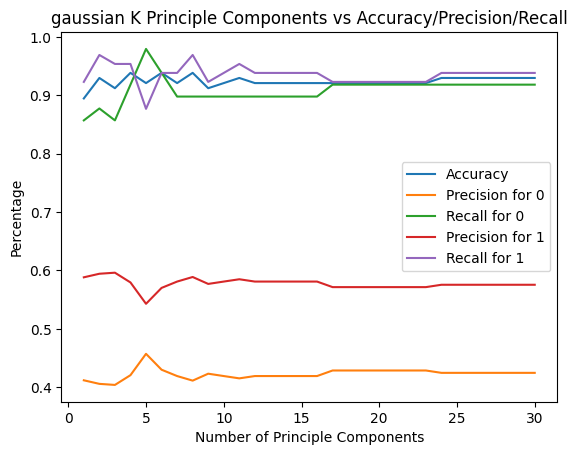

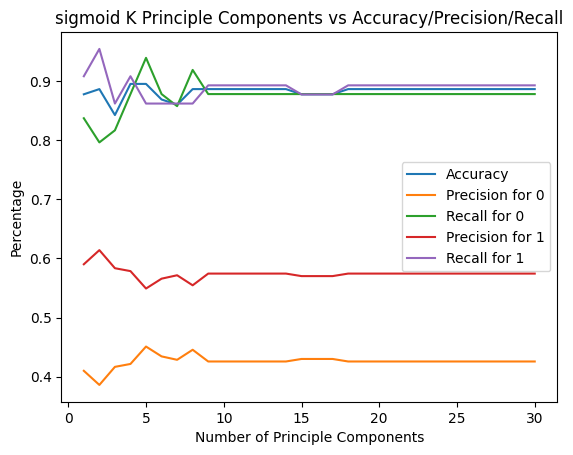

In [9]:
for nameIdx in range(len(kernelNames)):
    acc_list = kern_acc[nameIdx]
    prec0_list = kern_prec0[nameIdx]
    recall0_list = kern_recall0[nameIdx]
    prec1_list = kern_prec1[nameIdx]
    recall1_list = kern_recall1[nameIdx]

    print("{}: K with maximum accuracy = {}".format(kernelNames[nameIdx], np.argmax(acc_list)+1))
    print("{}: K with maximum precision for 0 = {}".format(kernelNames[nameIdx], np.argmax(prec0_list)+1))
    print("{}: K with maximum recall for 0 = {}".format(kernelNames[nameIdx], np.argmax(recall0_list)+1))
    print("{}: K with maximum precision for 1 = {}".format(kernelNames[nameIdx], np.argmax(prec1_list)+1))
    print("{}: K with maximum recall for 1 = {}".format(kernelNames[nameIdx], np.argmax(recall1_list)+1))

    plt.figure(nameIdx)
    plt.plot(range(1,31), acc_list, label="Accuracy")
    plt.plot(range(1,31), prec0_list, label="Precision for 0")
    plt.plot(range(1,31), recall0_list, label="Recall for 0")
    plt.plot(range(1,31), prec1_list, label="Precision for 1")
    plt.plot(range(1,31), recall1_list, label="Recall for 1")
    plt.title(kernelNames[nameIdx] + " K Principle Components vs Accuracy/Precision/Recall")
    plt.xlabel("Number of Principle Components")
    plt.ylabel("Percentage")
    plt.legend()

## Problem 2

In [10]:
from sklearn.svm import SVR

In [11]:
# Get dataset
df = pd.read_csv("../datasets/Housing.csv")
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [12]:
Y = df["price"].values
X = df[["area", "bedrooms", "bathrooms", "stories", "mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "parking", "prefarea"]].values
X[X=="yes"] = 1
X[X=="no"] = 0

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
tempOnes_train = np.ones((len(Y_train), 1))
tempOnes_test = np.ones((len(Y_test),1))
iterations = 100

In [14]:
# Scale the input
X_scaler = StandardScaler()
X_scaler.fit(X_train)
X_train_std = X_scaler.transform(X_train)
X_test_std = X_scaler.transform(X_test)

In [32]:
def svr(x, y, kernel, alpha=0.1, epsilon=1e3, iterations=100):
    theta = np.zeros(x.shape[0])
    for _ in range(iterations):
        err_mat = np.zeros(x.shape[0])
        for xIdx in range(x.shape[0]):
            sample = x[xIdx,:]
            kernelOut = kernel(x,sample)
            pred = kernelOut.dot(theta)
            err_mat[xIdx] = np.subtract(pred, y[xIdx])

        err_mat[np.abs(err_mat) <= epsilon] = 0
        delta = (alpha / len(y)) * err_mat
        theta = theta - delta

    return theta

In [36]:
kern_pred = []
kern_acc = []
for kernel in kernelFunc:
    pred_list = []
    acc_list = []
    for k in range(1,12):
        X_train_std_new = pca(X_train_std, k)
        X_test_std_new = pca(X_test_std, k)

        theta_x1 = svr(X_train_std_new, Y_train, kernel)

        pred_matrix = np.zeros(X_test_std_new.shape[0])
        for xIdx in range(X_test_std_new.shape[0]):
            sample = X_test_std_new[xIdx,:]
            kernelOut = kernel(X_train_std_new,sample)
            output = kernelOut.dot(theta_x1)
            pred_matrix[xIdx] = output

        pred_list.append(pred_matrix)

        acc_list.append(np.mean(pred_matrix - Y_test)**2)

    kern_pred.append(pred_list)
    kern_acc.append(acc_list)

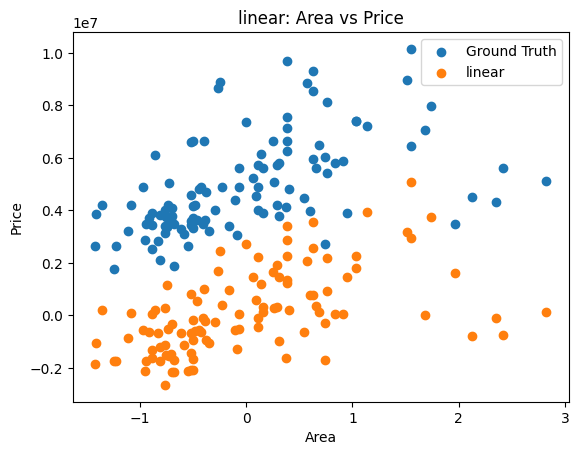

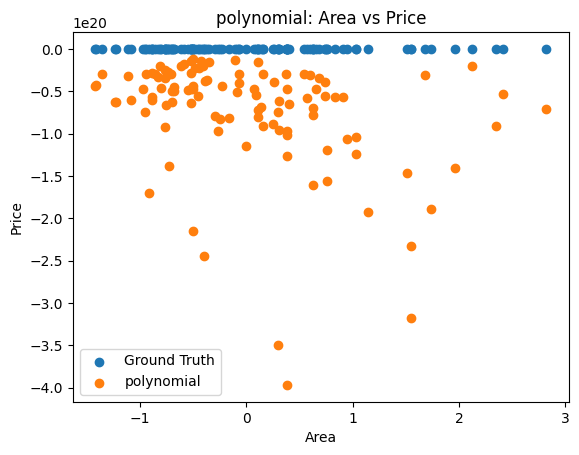

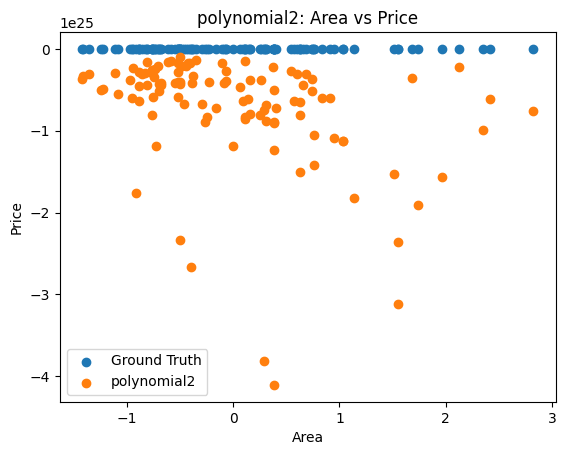

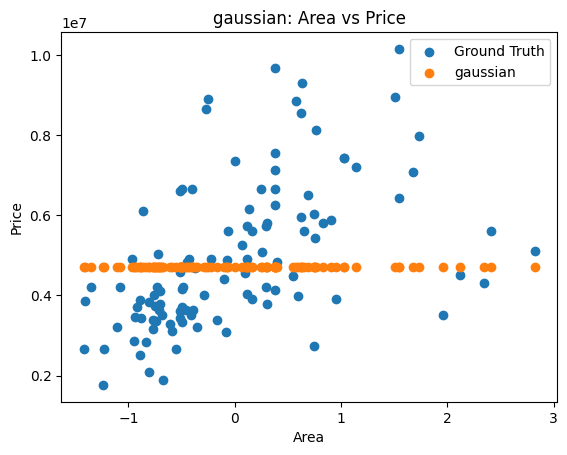

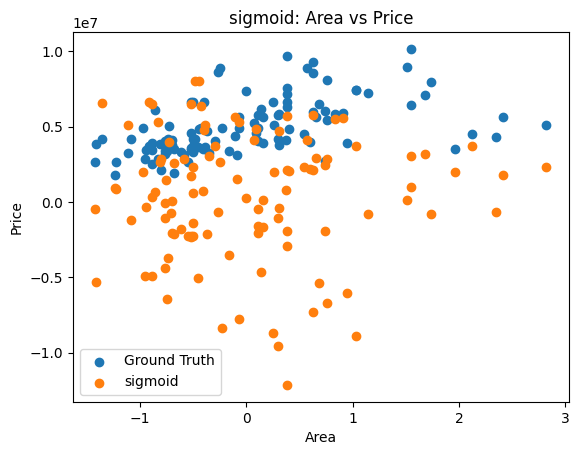

In [37]:
for nameIdx in range(len(kernelNames)):
    pred_list = kern_pred[nameIdx]

    plt.figure(nameIdx)
    plt.scatter(X_test_std[:,0], Y_test, label="Ground Truth")
    plt.scatter(X_test_std[:,0], pred_list[10], label=kernelNames[nameIdx])
    plt.title("{}: Area vs Price".format(kernelNames[nameIdx]))
    plt.xlabel("Area")
    plt.ylabel("Price")
    plt.legend()

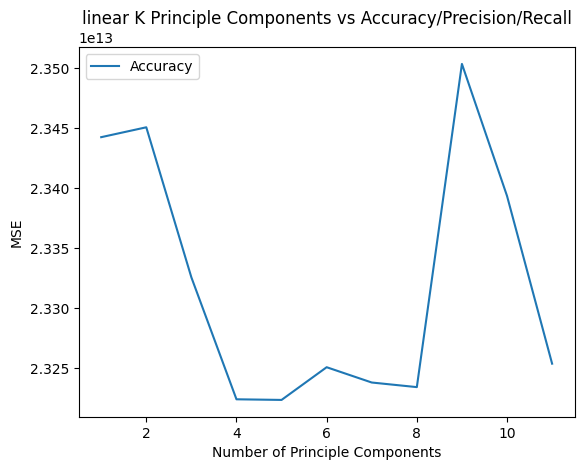

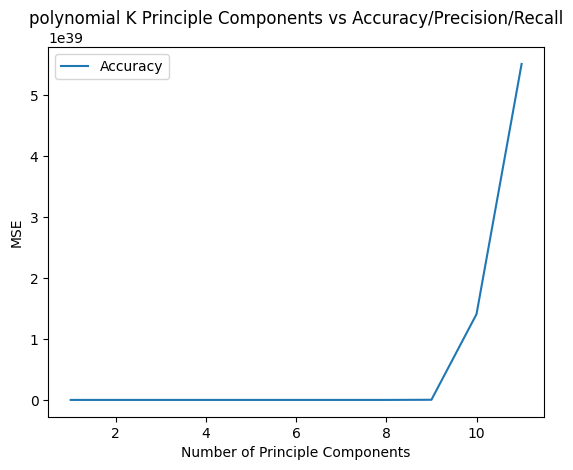

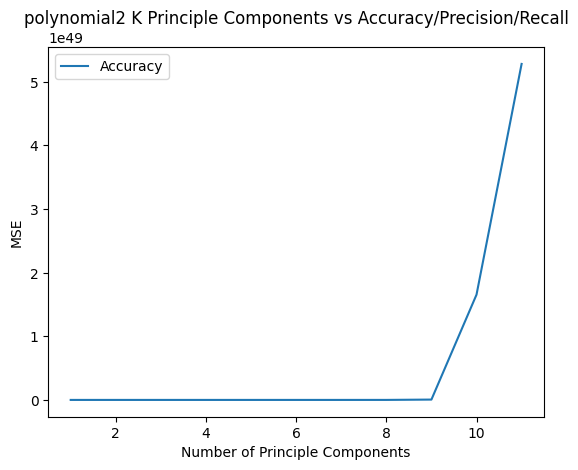

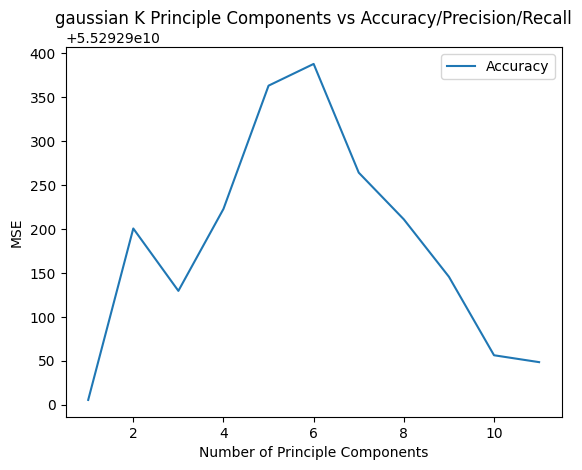

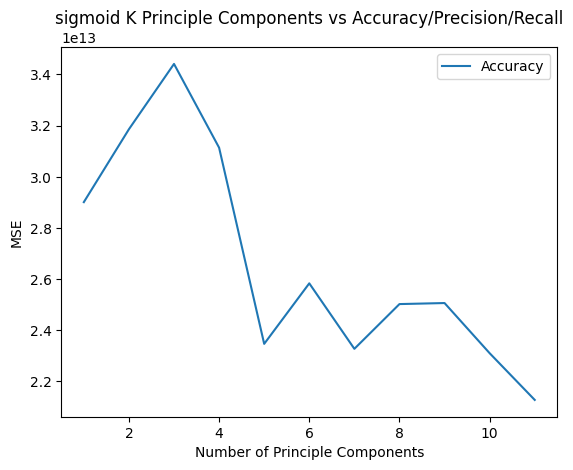

In [39]:
for nameIdx in range(len(kernelNames)):
    acc_list = kern_acc[nameIdx]

    plt.figure(nameIdx)
    plt.plot(range(1,12), acc_list, label="Accuracy")
    plt.title(kernelNames[nameIdx] + " K Principle Components vs Accuracy/Precision/Recall")
    plt.xlabel("Number of Principle Components")
    plt.ylabel("MSE")
    plt.legend()